# Different analysis / visualizations

In [1]:
import pandas as pd
import ast
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
from urllib.parse import urlencode
import requests

## Stack plot publisher

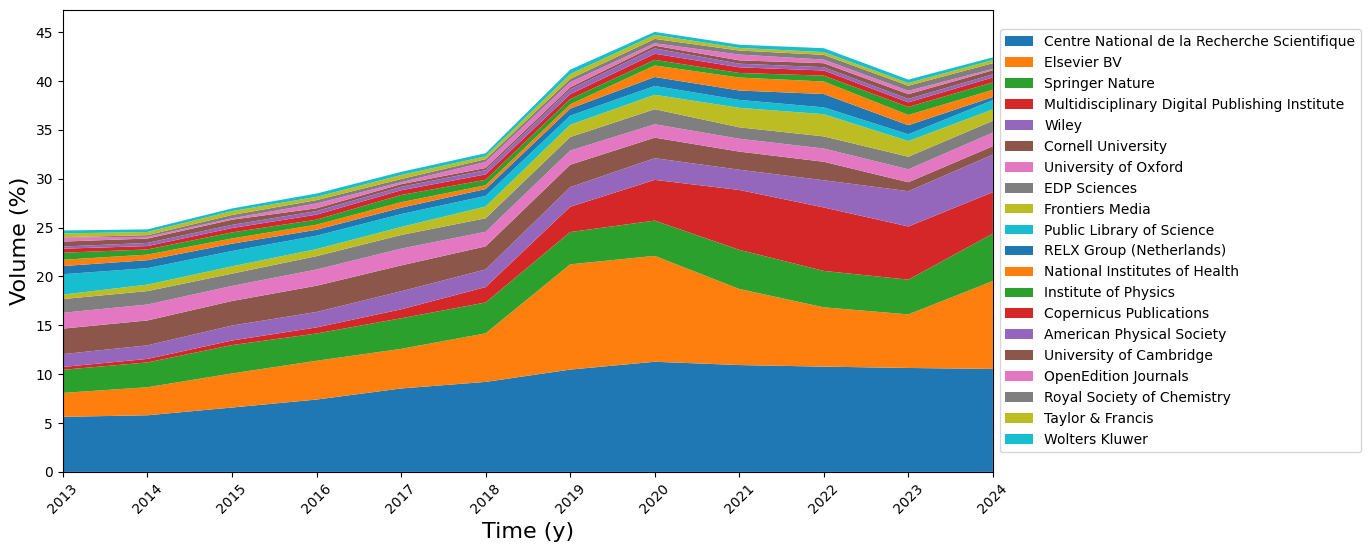

In [13]:
df_publishers = pd.read_csv('publishers.csv').drop(columns = 'Unnamed: 0')
df_tmp = df_interest.merge(df_publishers[['display_name', 'parent_publisher']], left_on = 'publisher', right_on = 'display_name', how = 'left').drop_duplicates('doi').reset_index(drop = True)

mask = (
    df_tmp['parent_publisher'].notna() &
    (df_tmp['parent_publisher'] != df_tmp['publisher'])
)

df_tmp.loc[mask, 'publisher'] = df_tmp.loc[mask, 'parent_publisher']

top_publishers = list(df_tmp.groupby('publisher').count().sort_values('doi', ascending = False)[0:20].index)
years = sorted(df_tmp.publication_year.unique())
df_per = pd.DataFrame(index = top_publishers, columns = years)
for year in years: 
    df_tmp_year = df_tmp[df_tmp.publication_year == year]  
    for publisher in top_publishers:
        df_tmp_year_year_publisher = df_tmp_year[df_tmp_year.publisher == publisher]            
        df_per.at[publisher, year] = df_tmp_year_year_publisher.doi.nunique() / df_tmp_year.doi.nunique()

fig, ax = plt.subplots(figsize=(12, 6))
ax.stackplot(df_per.columns.astype(int), df_per.values.astype(float) * 100, labels = df_per.index)
ax.set_xticks(np.arange(years[0], years[-1] + 1))
ax.set_xticklabels(np.arange(years[0], years[-1] + 1), rotation = 45)
ax.set_yticks(np.arange(0, 50, 5))
ax.set_yticklabels(np.arange(0, 50, 5))
ax.set_xlim(years[0], years[-1])
ax.set_ylabel('Volume (%)', fontsize = 16)  
ax.set_xlabel('Time (y)', fontsize = 16)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

## First plots volume-fund

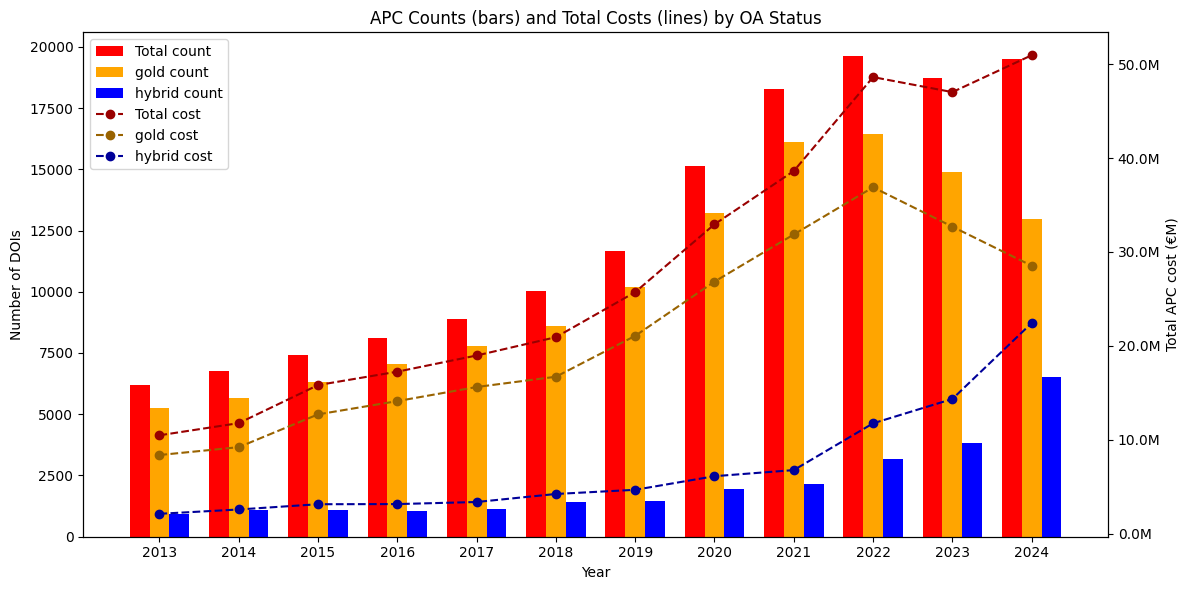

In [ ]:
### CANVIAR QUAN TINGUI EL FINAL

df = pd.read_csv('../data/interim/initial_dataset_elsevierwiliey.csv').drop(columns = 'Unnamed: 0')
df_money = pd.read_csv('EUR_USD_yearly_avg_2013_2024.csv').set_index('year')

df_apc_list = df[~df.apc_list.isna()].reset_index(drop = True)
df_apc_list['apc_list'] = df_apc_list.apc_list.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else {})
df_apc_list['value_usd'] = df_apc_list.apc_list.apply(lambda x: x['value_usd'])
df_apc_list['value_usd_to_eur'] = df_apc_list.apply(lambda x: x['value_usd']*df_money.at[x['publication_year'], 'avg_eur_per_usd'], axis = 1)

df_apc_list_oa_gold_hyb = df_apc_list[df_apc_list.oa_status.isin(['hybrid', 'gold'])].reset_index(drop = True)
status = df_apc_list_oa_gold_hyb.groupby(['publication_year', 'oa_status']).agg({'doi':'count', 'value_usd_to_eur': 'sum'})
total = df_apc_list_oa_gold_hyb.groupby(['publication_year']).agg({'doi':'count', 'value_usd_to_eur': 'sum'})
total['oa_status'] = 'Total'
total = total.set_index('oa_status', append=True)
df_data = pd.concat([status, total]).sort_index()

bar_width = 0.25
x = np.arange(len(years))

fig, ax1 = plt.subplots(figsize=(12,6))

colors = {'gold':'orange', 'hybrid':'blue', 'Total':'red'}

# Function to darken a color
def darken_color(color, amount=0.6):
    c = mcolors.to_rgb(color)
    return (c[0]*amount, c[1]*amount, c[2]*amount)

# Plot bars for counts
for i, col in enumerate(count_df.columns):
    ax1.bar(x + i*bar_width, count_df[col], width=bar_width, color=colors.get(col,'grey'), label=f"{col} count")

ax1.set_ylabel('Number of DOIs')
ax1.set_xlabel('Year')
ax1.set_xticks(x + bar_width)  # center x-ticks under grouped bars
ax1.set_xticklabels(years)

# Right axis for cost lines
ax2 = ax1.twinx()
for col in cost_df.columns:
    dark_color = darken_color(colors.get(col,'grey'))
    ax2.plot(x + bar_width, cost_df[col], color=dark_color, marker='o', linestyle='--', label=f"{col} cost")

# Format y-axis in millions
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x*1e-6:.1f}M'))

ax2.set_ylabel('Total APC cost (€M)')

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('APC Counts (bars) and Total Costs (lines) by OA Status')
plt.tight_layout()
plt.show()

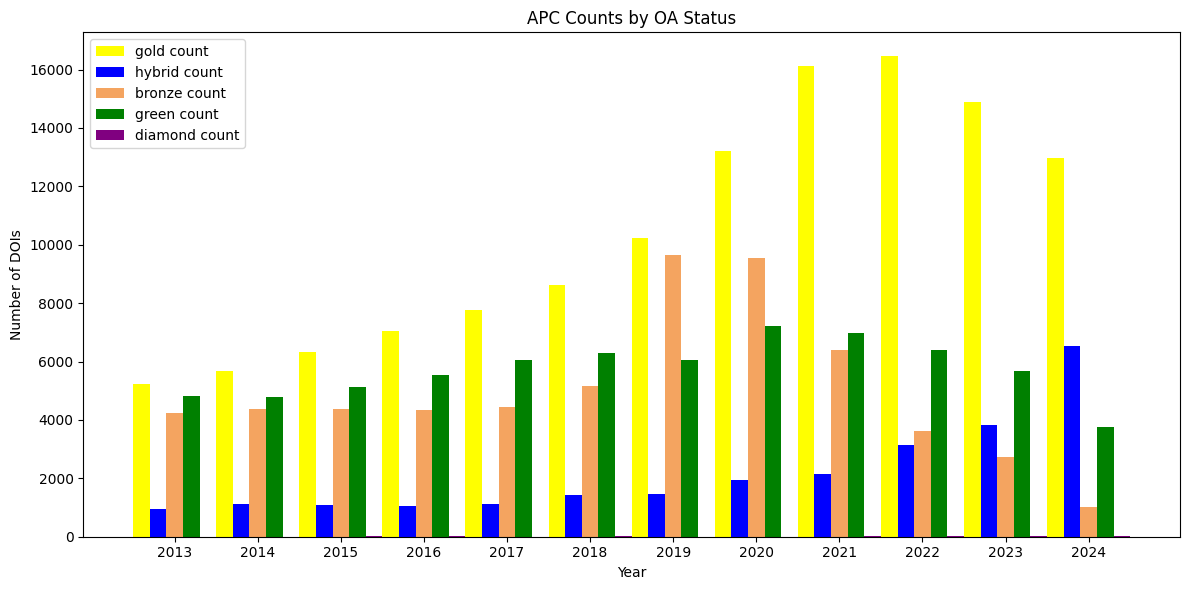

In [30]:
df_apc_list_oa = df_apc_list[df_apc_list.oa_status != 'closed'].reset_index(drop=True)

# Group and pivot counts
df_data = df_apc_list_oa.groupby(['publication_year', 'oa_status']).agg({'doi':'count'})
count_df = df_data['doi'].unstack('oa_status').fillna(0)

years = count_df.index
bar_width = 0.2
x = np.arange(len(years))

colors = {'gold':'yellow', 'hybrid':'blue', 'bronze':'sandybrown',
          'green':'green','diamond':'purple'}

desired_order = ['gold', 'hybrid', 'bronze', 'green', 'diamond']
count_df = count_df[desired_order]

fig, ax1 = plt.subplots(figsize=(12,6))

# Plot bars for counts
for i, col in enumerate(count_df.columns):
    ax1.bar(x + i*bar_width, count_df[col], width=bar_width,
            color=colors.get(col,'grey'), label=f"{col} count")

ax1.set_ylabel('Number of DOIs')
ax1.set_xlabel('Year')
ax1.set_xticks(x + bar_width*(len(count_df.columns)-1)/2)  # center x-ticks under grouped bars
ax1.set_xticklabels(years)

# Legend
ax1.legend(loc='upper left')

plt.title('APC Counts by OA Status')
plt.tight_layout()
plt.show()

In [16]:
df[df.apc_list.isna()].groupby('oa_status').count()[['doi']] / df.groupby('oa_status').count()[['doi']]

,doi
oa_status,
bronze,0.521987
closed,0.536831
diamond,0.998787
gold,0.103610
green,0.538264
hybrid,0.570123


## First-Last author primary topic distribution

In [2]:
col = 'Publication VoR date'
interest_status = ['Accepted', 'Not yet in EOAP', 'Pending']
df_elsevier = pd.read_csv('../data/external/Elsevier_EOAP_2225_Décembre.csv').dropna(subset = col)
df_elsevier['year'] = df_elsevier[col].apply(lambda x: int(x.split('/')[-1]))
df_elsevier = df_elsevier[(df_elsevier.year <= 2023)].reset_index(drop = True)
elsevier_doi = df_elsevier['Article DOI'].str.lower().unique().tolist()

BASE_URL = "https://api.openalex.org/works"

selected_fields = ["doi", "publication_year", "language", "indexed_in", "primary_location", "best_oa_location", "open_access", "authorships", 
                   "corresponding_author_ids", "corresponding_institution_ids", "apc_list", "apc_paid", "cited_by_count", "primary_topic", "awards", "funders"]


def fetch_by_ids(id_list):
    # Normalize IDs to a string separated by |
    doi_filter = "doi:" + "|".join(id_list)

    filters = [
        doi_filter,
        "indexed_in:crossref",
        "type:article|review",
    ]

    params = {
        "filter": ",".join(filters),
        "select": ",".join(selected_fields),
        "per_page": 200
    }

    url = f"{BASE_URL}?{urlencode(params)}"
    try:
        r = requests.get(url, timeout=30)
        r.raise_for_status()
        data = r.json()
        return data.get("results", [])
    except requests.exceptions.JSONDecodeError:
        print("JSON decode error for URL:", url[:200])
        pass
    except requests.exceptions.RequestException as e:
        print("Request error:", e)
        pass

batch_size = 50  # try increasing, test carefully
all_fetched = []
for i in tqdm(range(0, len(elsevier_doi), batch_size)):
    batch = elsevier_doi[i:i+batch_size]
    results = fetch_by_ids(batch)
    all_fetched.extend(results)

    
all_fetched_df = pd.json_normalize(all_fetched)
all_fetched_df

100%|██████████| 300/300 [03:34<00:00,  1.40it/s]


,doi,publication_year,language,indexed_in,authorships,corresponding_author_ids,corresponding_institution_ids,cited_by_count,awards,funders,...,primary_topic.subfield.display_name,primary_topic.field.id,primary_topic.field.display_name,primary_topic.domain.id,primary_topic.domain.display_name,apc_paid,best_oa_location,primary_topic,apc_list,best_oa_location.source
0,https://doi.org/10.1016/j.cscee.2023.100315,2023,en,"[crossref, doaj]","[{'author_position': 'first', 'author': {'id':...",[https://openalex.org/A5051466818],[],16,[],[],...,Virology,https://openalex.org/fields/24,Immunology and Microbiology,https://openalex.org/domains/1,Life Sciences,NaN,NaN,NaN,NaN,NaN
1,https://doi.org/10.1016/j.ajoc.2022.101281,2022,en,"[crossref, doaj, pubmed]","[{'author_position': 'first', 'author': {'id':...",[],[],13,[],[],...,Ophthalmology,https://openalex.org/fields/27,Medicine,https://openalex.org/domains/4,Health Sciences,NaN,NaN,NaN,NaN,NaN
2,https://doi.org/10.1016/j.mycmed.2022.101325,2022,en,"[crossref, pubmed]","[{'author_position': 'first', 'author': {'id':...",[https://openalex.org/A5022958322],"[https://openalex.org/I1294671590, https://ope...",13,[],[],...,Hematology,https://openalex.org/fields/27,Medicine,https://openalex.org/domains/4,Health Sciences,NaN,NaN,NaN,NaN,NaN
3,https://doi.org/10.1016/j.ajoc.2022.101588,2022,en,"[crossref, doaj, pubmed]","[{'author_position': 'first', 'author': {'id':...",[https://openalex.org/A5038584012],[https://openalex.org/I4210129146],11,[],[],...,"Radiology, Nuclear Medicine and Imaging",https://openalex.org/fields/27,Medicine,https://openalex.org/domains/4,Health Sciences,NaN,NaN,NaN,NaN,NaN
4,https://doi.org/10.1016/j.cscm.2023.e02764,2023,en,"[crossref, doaj]","[{'author_position': 'first', 'author': {'id':...",[],[],10,[],[],...,Civil and Structural Engineering,https://openalex.org/fields/22,Engineering,https://openalex.org/domains/3,Physical Sciences,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14858,https://doi.org/10.1016/j.mmm.2022.08.005,2022,fr,[crossref],"[{'author_position': 'first', 'author': {'id':...",[],[],0,[],"[{'id': 'https://openalex.org/F4320318638', 'd...",...,Nutrition and Dietetics,https://openalex.org/fields/29,Nursing,https://openalex.org/domains/4,Health Sciences,NaN,NaN,NaN,NaN,NaN
14859,https://doi.org/10.1016/j.therap.2022.09.008,2022,fr,"[crossref, pubmed]","[{'author_position': 'first', 'author': {'id':...",[https://openalex.org/A5058258538],"[https://openalex.org/I3019448017, https://ope...",0,[],"[{'id': 'https://openalex.org/F4320320883', 'd...",...,General Health Professions,https://openalex.org/fields/36,Health Professions,https://openalex.org/domains/4,Health Sciences,NaN,NaN,NaN,NaN,NaN
14860,https://doi.org/10.1016/j.lpm.2023.104165,2023,en,"[crossref, pubmed]","[{'author_position': 'first', 'author': {'id':...",[https://openalex.org/A5050789021],"[https://openalex.org/I100532134, https://open...",0,[],"[{'id': 'https://openalex.org/F4320320883', 'd...",...,Emergency Medicine,https://openalex.org/fields/27,Medicine,https://openalex.org/domains/4,Health Sciences,NaN,NaN,NaN,NaN,NaN
14861,https://doi.org/10.1016/j.mmm.2023.03.012,2023,fr,[crossref],"[{'author_position': 'first', 'author': {'id':...",[https://openalex.org/A5014371425],"[https://openalex.org/I154526488, https://open...",0,[],"[{'id': 'https://openalex.org/F4320320883', 'd...",...,Epidemiology,https://openalex.org/fields/27,Medicine,https://openalex.org/domains/4,Health Sciences,NaN,NaN,NaN,NaN,NaN


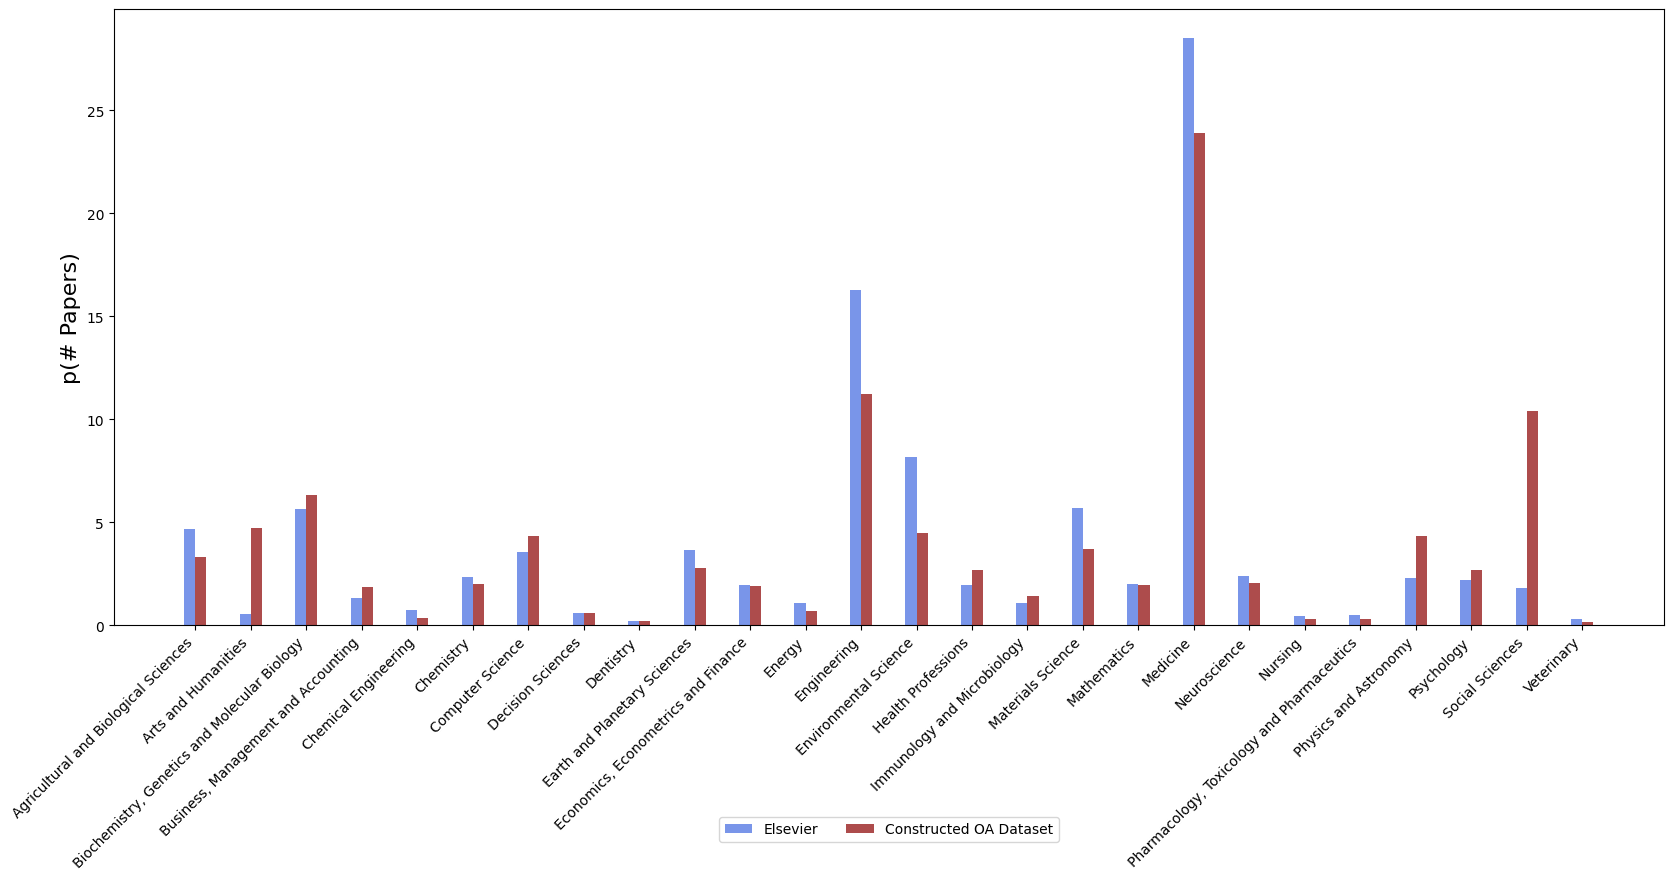

In [ ]:
df_tmp = all_fetched_df.merge(df_elsevier[['Article DOI', 'Corresponding author name']], left_on = all_fetched_df.doi.apply(lambda x: x[16::].lower()), right_on = df_elsevier['Article DOI'].str.lower(), how = 'inner')[['doi', 'primary_topic.field.display_name']]
grouped_els = df_tmp.groupby(['primary_topic.field.display_name']).count()[['doi']].rename(columns={'doi': 'elsevier'}) / df_tmp.doi.nunique() * 100

df = pd.read_csv('../data/interim/initial_dataset_elsevierwiliey.csv').drop(columns = 'Unnamed: 0')
df_years = df[(df.publication_year >= 2020) & (df.publication_year <= 2023)]

grouped_oa = df_years.groupby(['field_name_top_topic']).count()[['doi']].rename(columns={'doi': 'oa'}) / df_years.doi.nunique() * 100

df_tmp_1 = grouped_els.merge(grouped_oa, left_index = True, right_index = True, how = 'inner')

fig, axs = plt.subplots(1, 1, figsize=(20, 8))
fig.subplots_adjust(hspace=0.4)

width = 0.2
offsets = [-0.5*width, 0.5*width]

x_positions = np.arange(len(df_tmp_1.index))

axs.bar(x_positions + offsets[0], df_tmp_1.elsevier, width, color='royalblue', alpha=0.7, label='Elsevier')
axs.bar(x_positions + offsets[1], df_tmp_1.oa, width, color='darkred', alpha=0.7, label='Constructed OA Dataset')

axs.set_ylabel('p(# Papers)', fontsize = 16)
axs.set_xticks(x_positions)
axs.set_xticklabels([f"{name}" for name in df_tmp_1.index], rotation=45, ha='right')

axs.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=2)


In [33]:
df_tmp_1['change'] = abs(df_tmp_1.elsevier - df_tmp_1.oa) / df_tmp_1.elsevier * 100
df_tmp_1.sort_values('change', ascending = False)

,elsevier,oa,change
Arts and Humanities,0.545014,4.709557,764.116447
Social Sciences,1.796528,10.395910,478.666744
Physics and Astronomy,2.287714,4.307686,88.296537
Chemical Engineering,0.746871,0.346933,53.548454
Veterinary,0.302786,0.148058,51.101442
Environmental Science,8.188669,4.458765,45.549577
"Business, Management and Accounting",1.305342,1.859650,42.464527
Health Professions,1.951285,2.672732,36.972897
"Pharmacology, Toxicology and Pharmaceutics",0.491186,0.317267,35.407971
Energy,1.076571,0.695789,35.369873
